In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.utils import treat_string

In [2]:
df_meps = pd.read_csv('./data/meps.csv')
df_meetings = pd.read_csv('./data/meetings.csv', dtype={"member_id": str})
df_tr = pd.read_excel(r"D:\OneDrive\UFPR\00.PPGCP\00. Doutorado\Tese\Base de dados\Transparency register\Organisations in Transparency Register-2024-JAN.xls")

C:\Users\caca_\AppData\Local\Temp\ipykernel_17188\2347258177.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meetings = pd.read_csv('./data/meetings.csv', dtype={"member_id": str})


In [3]:
df_tr['t_name'] = df_tr['Name'].apply(treat_string)
df_meetings['t_name'] = df_meetings['attendees'].apply(treat_string)

In [4]:
cat_mapper = {
    "Non-governmental organisations, platforms and networks and similar": "NGOs",
    "Trade and business associations": "Business",
    "Companies & groups": "Business",
    "Other organisations, public or mixed entities": "Other",
    "Trade unions and professional associations": "Other",
    "Self-employed individuals": "Other",
    "Think tanks and research institutions": "Other",
    "Professional consultancies": "Other",
    "Academic institutions": "Other",
    "Associations and networks of public authorities": "Other",
    "Organisations representing churches and religious communities": "Other",
    "Law firms": "Other",
    "Entities, offices or networks established by third countries": "Other",
}


df_merge = df_meetings.merge(df_tr, on='t_name')

df_merge['month'] = df_merge['meeting_date'].apply(lambda x: '-'.join(x.split('-')[:2]))
df_merge['cat_mapped'] = df_merge['Category of registration'].apply(lambda x: cat_mapper.get(x))

len(df_merge)

20934

In [5]:
# df_merge[['month', 'Category of registration']]
df_g_n_meetings = (
    df_merge[["month"]]
    .join(pd.get_dummies(df_merge[["cat_mapped"]]))
    .groupby("month")
    .sum()
    .reset_index()
)

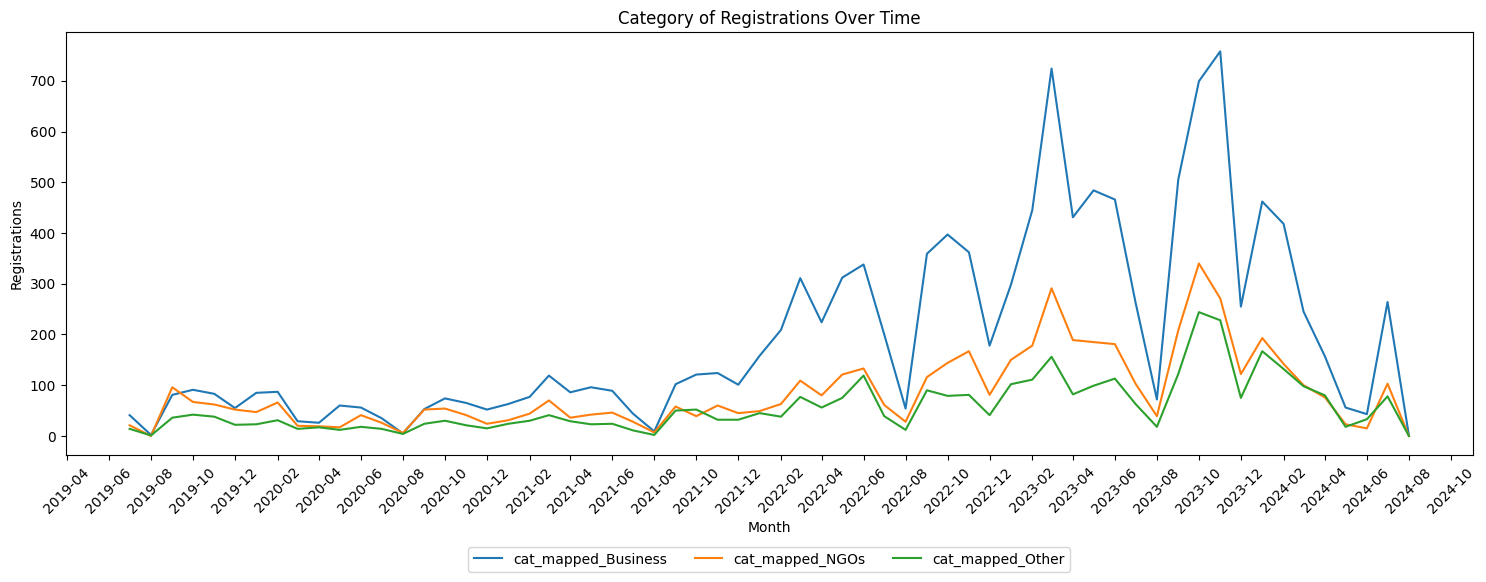

In [6]:
# Convert 'month' column to datetime
df = df_g_n_meetings.copy()
df['month'] = pd.to_datetime(df['month'])

# Set 'month' as the index for better plotting
df.set_index('month', inplace=True)

# Plot each column
plt.figure(figsize=(15, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Registrations')
plt.title('Category of Registrations Over Time')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Set legend at the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
df_meetings[['attendees', 'title']].groupby('attendees').count().sort_values('title', ascending=False).to_csv('teste.csv')

In [19]:
df_meetings[['member_id', 'member_capacity', 'title']].groupby(["member_id","member_capacity"]).count()

title
member_id member_capacity                     
101039    Rapporteur for opinion             1
          Shadow rapporteur                  9
          Shadow rapporteur for opinion      1
101585    Member                           307
          Rapporteur                        13
...                                        ...
98582     Rapporteur                         1
99283     Member                             3
99945     Member                            12
          Rapporteur                         5
          Shadow rapporteur                 39

[1850 rows x 1 columns]